In [ ]:
import os

# Path to Audio data
Savee = r"E:\machine learning work area\internship tasks\codealpha\CodeAlpha_Emotion_Recognition_from_Speech-main\CodeAlpha_Emotion_Recognition_from_Speech-main\speechs.csv"

# Check if Savee exists and if it's a directory
if os.path.exists(Savee) and os.path.isdir(Savee):
    # Get the list of directories
    directory_list = next(os.walk(Savee))[1]
    print(directory_list)
else:
    print("The specified path is either invalid or it's not a directory.")


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio
import warnings

import tensorflow.keras as tf
warnings.filterwarnings("ignore")

 ### Classify spoken sentences into different emotions like (happiness, anger, or sadness)
 ##### Data Preparation and Accessing from FilePath

In [3]:
pd.set_option('display.max_rows', 500)
file_emotion = []

file_path = []

for i in directory_list:
    actor = os.listdir(Savee + "/" +i)
    for file in actor:
        #[:-6] is a slicing operation that extracts a substring from the beginning of the string 
        
        if len(file) == 7 or len(file) == 8:
            file_emotion.append(file[:-6])

        file_path.append(Savee+"/"+i+"/"+file)

# list to dataframe (basically a table)
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combining
Savee_df = pd.concat([emotion_df,path_df], axis=1)

#letter to full emotion
Savee_df.Emotions.replace({'a':'Angry', 'd':'Disgusted', 'f':'Fear', 'h':'Happy', 'n':'Neutral', 'sa':'Sad', 'su':'Surprised'}, inplace=True)
#If no argument is passed to head(), it defaults to head(5), returning the first 5 rows.

Savee_df["Emotions"].value_counts()



Emotions
Neutral      120
Happy         60
Sad           60
Disgusted     60
Fear          60
Surprised     60
Angry         60
Name: count, dtype: int64

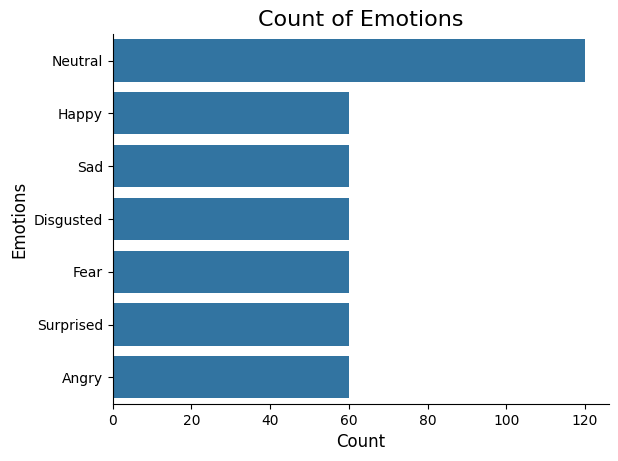

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(Savee_df.Emotions)
plt.ylabel('Emotions', size=12)
plt.xlabel('Count', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Plotting Waveplots for Audio Signals For The Emotion 'Fear' as an example 
#### represnt one sample

In [5]:
def c_waveplot(data,sampling_rate,emotion):
    plt.figure(figsize=(10,5))
    plt.title('Waveplot for emotion {}'.format(emotion),size=12)
    librosa.display.waveshow(data,sr=sampling_rate, color='b')
    plt.show()

In [6]:
def c_spectogram(data, sampling_rate, emotion):
    x = librosa.stft(data)
    xdB = librosa.amplitude_to_db(np.abs(x))
    plt.figure(figsize=(12,6))
    plt.title('Spectogram for emotion {}'.format(emotion),size=12)
    librosa.display.specshow(xdB, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

/Users/yousefelbrolosy/dev/projects/Python ML/kaggle/Savee Database/AudioData/KL/f09.wav


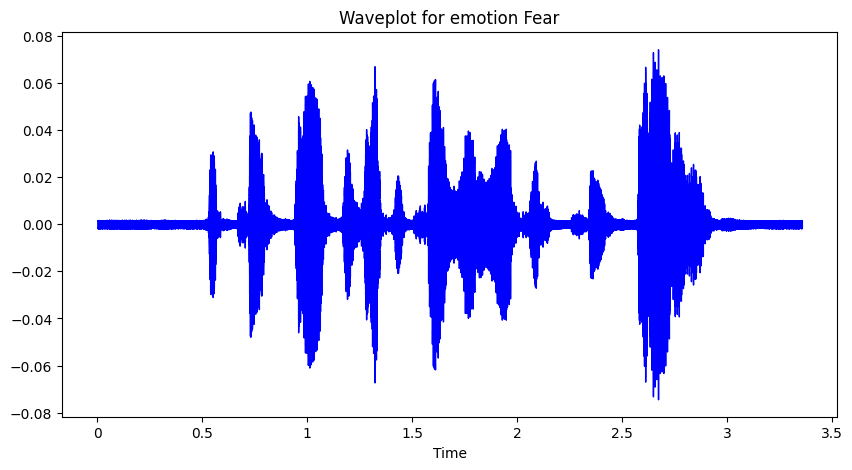

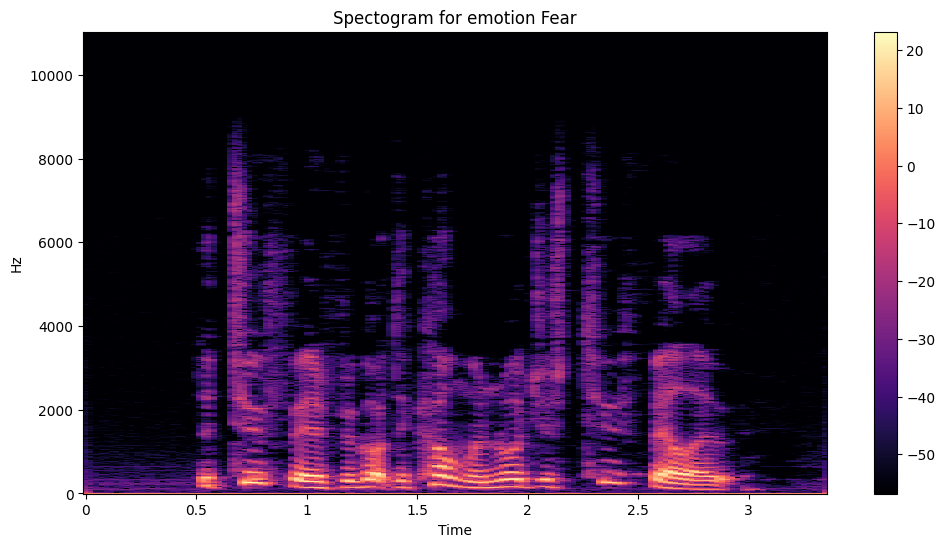

In [7]:
emotion = 'Fear'
path = np.array(Savee_df.Path[Savee_df.Emotions==emotion])[0]
print(path)
data, sampling_rate = librosa.load(path)
c_waveplot(data,sampling_rate,emotion)
c_spectogram(data,sampling_rate,emotion)
Audio(path)

## Adding small pertubations on the data set by:
### 1- injecting noise 


In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data+noise_amp*np.random.normal(size=data.shape[0])
    return data

### 2- shifting time 

In [9]:
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)

This function randomly shifts the elements of the input numpy array data by a random amount within the range of -5000 to 5000 (approximately). 

In [10]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

In [11]:
def pitch(data, sampling_rate,pitch_factor=0.7):
    return librosa.effects.pitch_shift(data,sr=sampling_rate,n_steps=pitch_factor)

In [12]:
path = np.array(Savee_df.Path[Savee_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)

Normal Audio

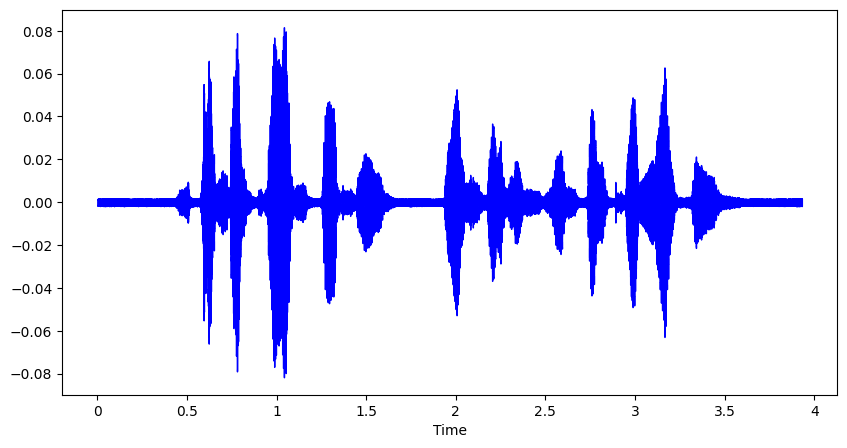

In [13]:
plt.figure(figsize=(10,5))
librosa.display.waveshow(data,sr=sampling_rate, color='b')
Audio(path)

audio after Noise

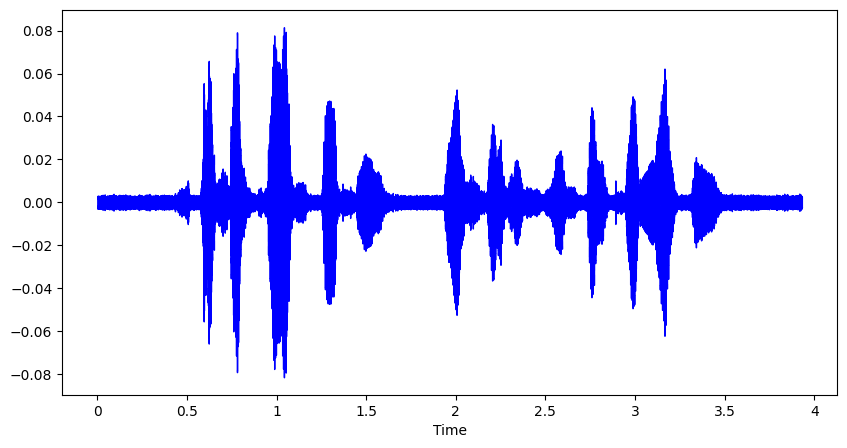

In [14]:
n = noise(data)
plt.figure(figsize=(10,5))
librosa.display.waveshow(n,sr=sampling_rate, color='b')
Audio(path, rate=sampling_rate)

### 3- changing speed Stretching


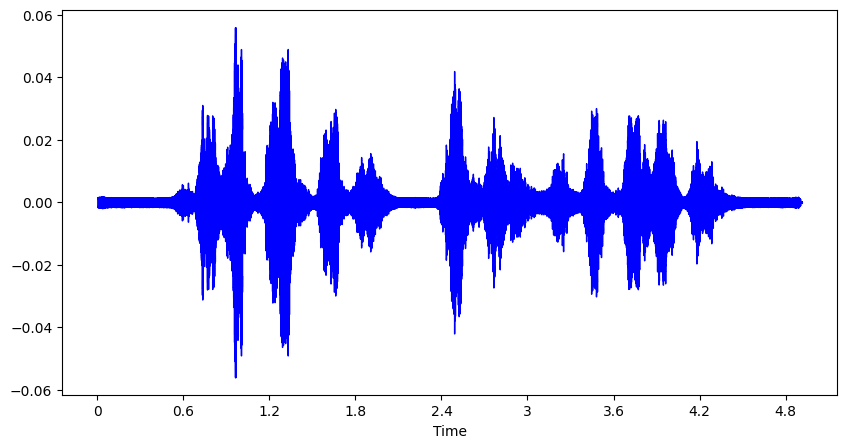

In [15]:
s = stretch(data)
plt.figure(figsize=(10,5))
librosa.display.waveshow(s,sr=sampling_rate, color='b')
Audio(path, rate=sampling_rate)

Shift

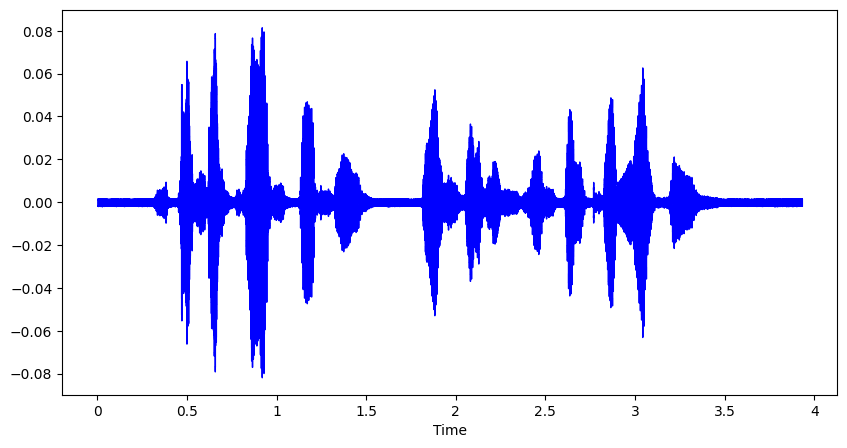

In [16]:
sh = shift(data)
plt.figure(figsize=(10,5))
librosa.display.waveshow(sh,sr=sampling_rate,color='b')
Audio(sh,rate=sampling_rate)

### 4- changing Pitch

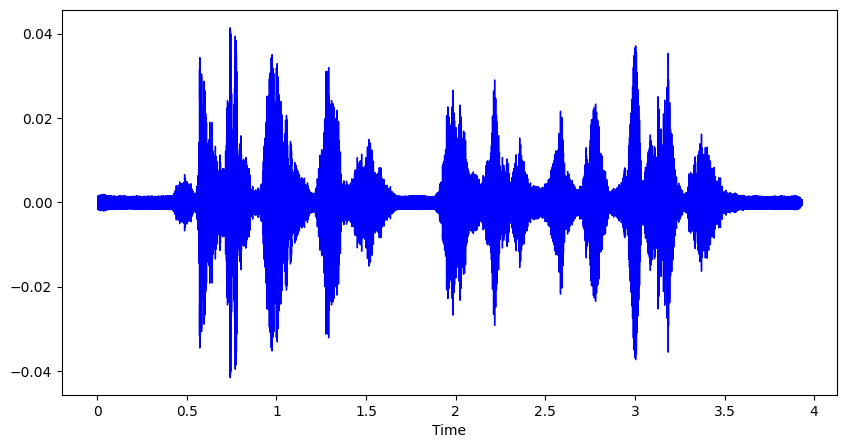

In [17]:
p = pitch(data, sampling_rate=sampling_rate)
plt.figure(figsize=(10,5))
librosa.display.waveshow(p,sr=sampling_rate,color='b')
Audio(data,rate=sampling_rate)

### Extracting Features

In [18]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr)) 

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel_s = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mel_s))
    
    return result



In [19]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    normal = extract_features(data)
    result = np.array(normal)
    
    # noise
    noise_data = noise(data)
    aug1 = extract_features(noise_data)
    result = np.vstack((result, aug1)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretched_pitch = pitch(new_data, sample_rate)
    aug2 = extract_features(data_stretched_pitch)
    result = np.vstack((result, aug2)) # stacking vertically
    
    return result

try:
  print(name)
except NameError:
  print("Variable name is not defined")
except:
  print("Something went wrong")

In [20]:
x, y = [],[]
count = 0
# zip() function in Python is used to combine multiple iterables (such as lists, tuples, or other sequences) element-wise into a single iterable
try:
    for path, emotion in zip(Savee_df.Path, Savee_df.Emotions):
 
        feature = get_features(path)
        for aug in feature:
            x.append(aug)
            # because we have three augmentations for the same emotion (we would have 480*3)
            y.append(emotion)
        count+=1
except:
    print("error")
finally:
    print(list(zip(Savee_df.Path, Savee_df.Emotions))[count-1],count)


('/Users/yousefelbrolosy/dev/projects/Python ML/kaggle/Savee Database/AudioData/JK/n26.wav', 'Neutral') 480


In [36]:
features = pd.DataFrame(x)
features['labels'] = y
features.to_csv('features.csv', index=False)
features.head()

ValueError: Expected a 1D array, got an array with shape (1440, 7)

## Data Preparation

### This is a classification Problem

### We want to extract only the numerical data from the features Dataframe

In [22]:
x = features.iloc[:, :-1].values
y = features['labels'].values

We want to one hot encode our Y because in classification algorithms we only accept numerical data

This line converts the input y into a NumPy array and reshapes it into a column vector. The -1 in the reshape function means that NumPy should automatically infer the number of rows based on the number of elements in the array.

In [23]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

## Splittintg Data into train and Test

In [24]:
from sklearn.model_selection import train_test_split
#what happens if random state is 100
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0,shuffle=True)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1152, 162), (1152, 7), (288, 162), (288, 7))

#### Further Preprocessing by scaling standardizes features by removing the mean and scaling to unit variance.

In summary, fit_transform is used for the initial fitting and transformation of the training data, while transform is used for applying the same transformation to new data based on the parameters learned from the training data. It's important to use transform for test or validation data to ensure consistency with the scaling applied to the training data.

In [25]:
from sklearn.discriminant_analysis import StandardScaler


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
#This method applies the same transformation (scaling) to the new data that was learned from the training data without refitting the scaler.
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1152, 162), (1152, 7), (288, 162), (288, 7))

#### Next we make our data compatible with the model we are going to use

In [26]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test,axis=2)

### We will use Keras (deeplearning) Sequential Model

We create a Sequential model and add layers one at a time until we are happy with our network architecture.

In [27]:
model = tf.keras.Sequential([
    tf.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1],1)),
    tf.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
    
    tf.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
    
    tf.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
    
    tf.layers.Dropout(0.2),
    
    tf.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
    
    tf.layers.Flatten(),
    tf.layers.Dense(units=32, activation='relu'),
    
    tf.layers.Dropout(0.3),
    
    tf.layers.Dense(units=7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 256)           327936    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 256)           0

In [28]:
rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test,y_test),callbacks=[rlrp])

Epoch 1/50
18/18 [==============================] - 2s 81ms/step - loss: 1.8933 - accuracy: 0.2578 - val_loss: 1.7990 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 1s 72ms/step - loss: 1.7710 - accuracy: 0.2925 - val_loss: 1.7186 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 1s 74ms/step - loss: 1.6858 - accuracy: 0.3142 - val_loss: 1.6479 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 1s 82ms/step - loss: 1.6796 - accuracy: 0.3090 - val_loss: 1.5496 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - 1s 82ms/step - loss: 1.5905 - accuracy: 0.3446 - val_loss: 1.4512 - val_accuracy: 0.3924 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - 1s 74ms/step - loss: 1.5430 - accuracy: 0.3576 - val_loss: 1.4183 - val_accuracy: 0.4097 - lr: 0.0010
Epoch 7/50
18/18 [==============================] - 1s 75ms/step - loss: 1.4

#### Note How the Accuracy increases as The Epoch (Sequencing hapens?)
Will probably increase as we increse the Epoch

## Calculating Accuracy

Loss value quantifies the difference between the predicted output of the model and the actual target values in the training data.

In [29]:
print("Accuracy on test data : ", model.evaluate(x_test,y_test)[1]*100, "%")
print("Loss value on test data : ", model.evaluate(x_test,y_test)[0])
# I think Loss unit is the numerical values in the feature df?


9/9 [==============================] - 0s 14ms/step - loss: 0.9697 - accuracy: 0.6319
Accuracy on test data :  63.19444179534912 %
9/9 [==============================] - 0s 12ms/step - loss: 0.9697 - accuracy: 0.6319
Loss value on test data :  0.9697079062461853


#### Plotting Accuracy and Loss Values

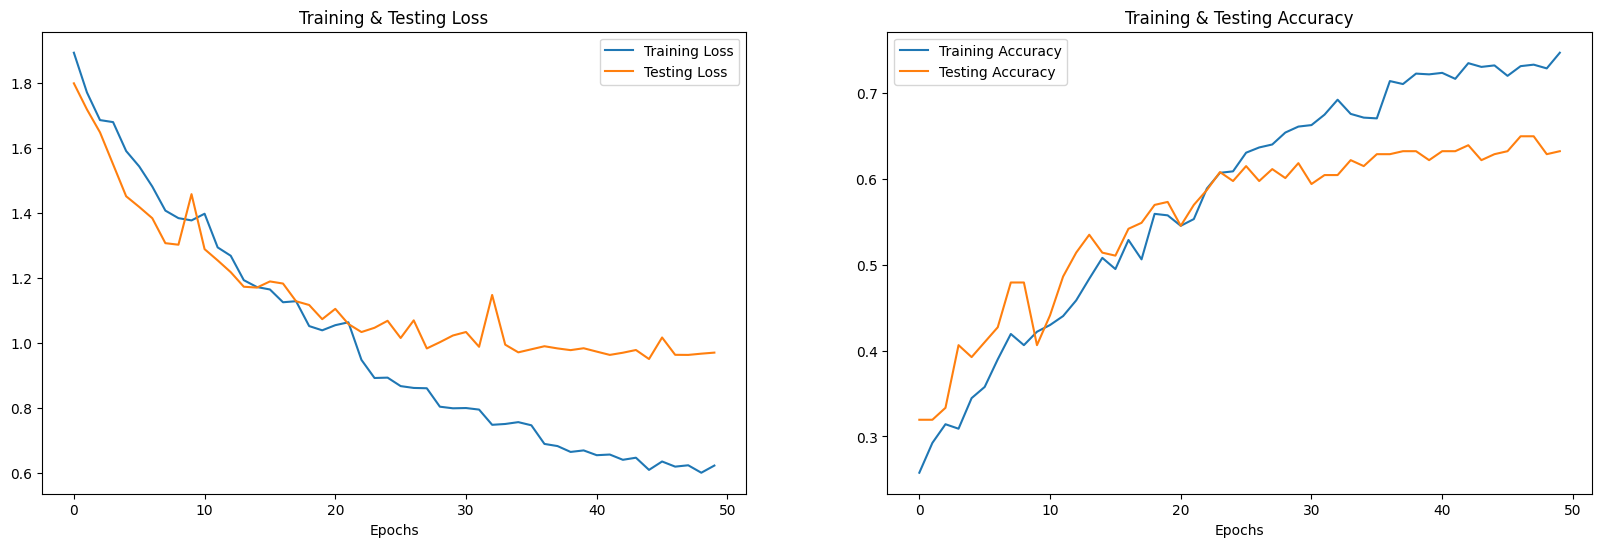

In [30]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### The Predictions model did on Test Data? 

In [31]:
predicted = model.predict(x_test)
y_predicted = encoder.inverse_transform(predicted)

y_test = encoder.inverse_transform(y_test)


9/9 [==============================] - 0s 13ms/step


In [32]:
df = pd.DataFrame(columns=['Predicted Emotion','Actual Emotion'])
df['Predicted Emotion'] = y_predicted.flatten()
df['Actual Emotion'] = y_test.flatten()

df.head(20)

,Predicted Emotion,Actual Emotion
0,Fear,Happy
1,Neutral,Disgusted
2,Surprised,Surprised
3,Neutral,Disgusted
4,Surprised,Surprised
5,Neutral,Neutral
6,Angry,Angry
7,Neutral,Neutral
8,Neutral,Neutral
9,Neutral,Neutral


In [33]:
from sklearn.metrics import classification_report


print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

       Angry       0.74      0.50      0.60        40
   Disgusted       0.60      0.58      0.59        36
        Fear       0.43      0.35      0.39        34
       Happy       0.67      0.61      0.64        36
     Neutral       0.78      0.80      0.79        70
         Sad       0.65      0.73      0.69        33
   Surprised       0.48      0.69      0.57        39

    accuracy                           0.63       288
   macro avg       0.62      0.61      0.61       288
weighted avg       0.64      0.63      0.63       288

